In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
from tensorflow import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras_preprocessing.image import array_to_img

# Data Preparation

#### ***You can download the data from here.***
<https://www.kaggle.com/competitions/digit-recognizer/data>

### Load the Data

In [6]:
print(*glob.glob('dataset/*'), sep='\n')

dataset\test.csv
dataset\train.csv


In [8]:
df_train = pd.read_csv('dataset/train.csv')
df_train.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_train.shape

(42000, 785)

### Create Feature and Target variable

In [10]:
y = df_train['label'].values
X = df_train.drop('label', axis=1).values

### Reshape the Data

In [6]:
X = X.reshape(-1, 28, 28, 1)

### Label Encoding

In [7]:
y = to_categorical(y)
print(y.shape)
print(y[0])

(42000, 10)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


# Split the Data into Training and Validation

In [8]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=34, shuffle=True)


In [9]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((37800, 28, 28, 1), (37800, 10), (4200, 28, 28, 1), (4200, 10))

# CNN-Arcitecture

In [10]:
from keras import Sequential
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler, learning_rate_schedule

In [11]:
lr_rate = 0.0001

In [12]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(X.shape[1:])))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation='softmax'))


2022-11-17 00:31:17.368076: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 00:31:17.461017: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 00:31:17.461933: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-17 00:31:17.464040: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [13]:
model.compile(optimizer=Adam(learning_rate=lr_rate), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 128)         0

In [14]:
BATCH_SIZE = 128
EPOCHES = 50

train_steps = x_train.shape[0] // BATCH_SIZE
val_steps = x_val.shape[0] // BATCH_SIZE

# Callbacks

In [15]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           mode='max',
                           verbose=1,
                           restore_best_weights=True,
                           )

red_plateau = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.5,
                                patience=5,
                                verbose=1,
                                min_delta=0.00001,
                                mode='max',                                
                                )

callbacks = [early_stop, red_plateau]

## training

In [16]:
history = model.fit(x_train, y_train,
          steps_per_epoch=train_steps,
          batch_size=BATCH_SIZE, epochs=EPOCHES,
          validation_data=(x_val, y_val),
          validation_steps=val_steps,
          callbacks=callbacks,
          verbose=1
          )


2022-11-17 00:31:20.848871: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-11-17 00:31:22.348722: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


295/295 [==============================] - 11s 13ms/step - loss: 0.1807 - accuracy: 0.9468 - val_loss: 0.0817 - val_accuracy: 0.9766
Epoch 2/50
295/295 [==============================] - 3s 11ms/step - loss: 0.0334 - accuracy: 0.9915 - val_loss: 0.0464 - val_accuracy: 0.9871
Epoch 3/50
295/295 [==============================] - 3s 11ms/step - loss: 0.0132 - accuracy: 0.9977 - val_loss: 0.0453 - val_accuracy: 0.9858
Epoch 4/50
295/295 [==============================] - 4s 12ms/step - loss: 0.0055 - accuracy: 0.9995 - val_loss: 0.0388 - val_accuracy: 0.9885
Epoch 5/50
295/295 [==============================] - 4s 12ms/step - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.0388 - val_accuracy: 0.9893
Epoch 6/50
295/295 [==============================] - 3s 11ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0384 - val_accuracy: 0.9890

Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 7/50
295/295 [==============================] - 3s 11ms/step - lo

# Evaluation

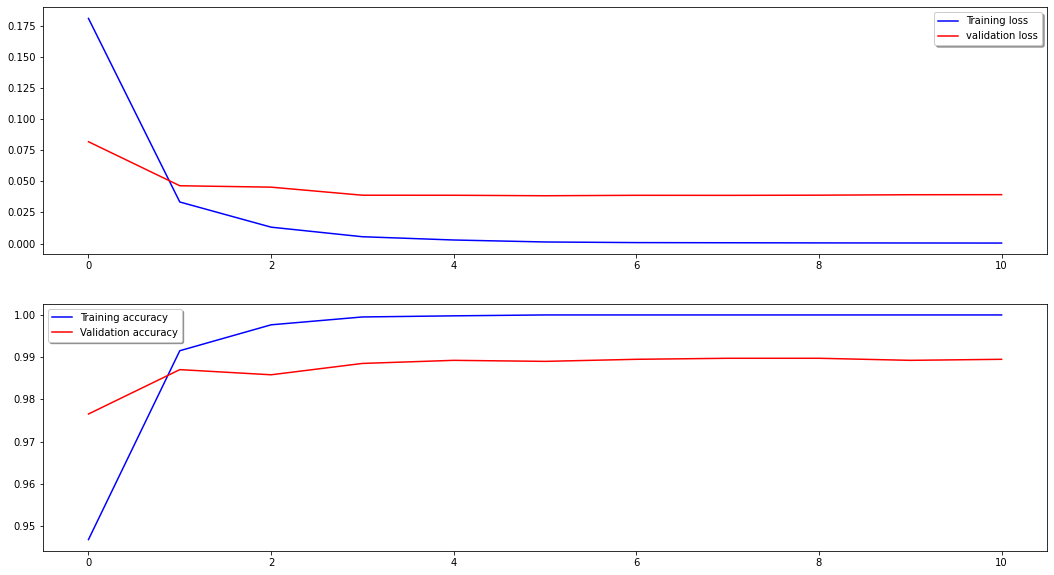

In [17]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Evaluate model on mnist dataset to quick check its accuracy

In [18]:
from keras.datasets import mnist
(x_train_load, y_train_load), (x_test, y_test) = mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


In [19]:
# x_test = x_test // 255.0
x_test = x_test.reshape(-1, 28, 28, 1)

y_test = to_categorical(y_test)

x_test.shape, y_test.shape

((10000, 28, 28, 1), (10000, 10))

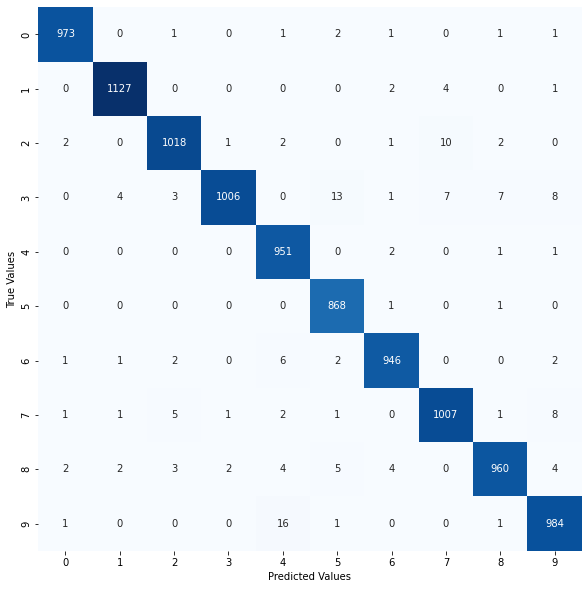

In [20]:
fig = plt.figure(figsize=(10, 10)) # Set Figure

y_pred = model.predict(x_test) # Predict class probabilities as 2 => [0.1, 0, 0.9, 0, 0, 0, 0, 0, 0, 0]

Y_pred = np.argmax(y_pred, 1) # Decode Predicted labels
Y_test = np.argmax(y_test, 1) # Decode labels

mat = confusion_matrix(Y_test, Y_pred) # Confusion matrix

# Plot Confusion matrix
sns.heatmap(mat.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

In [21]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.96      1.00      0.98      1010
           4       1.00      0.97      0.98       982
           5       1.00      0.97      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.99      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



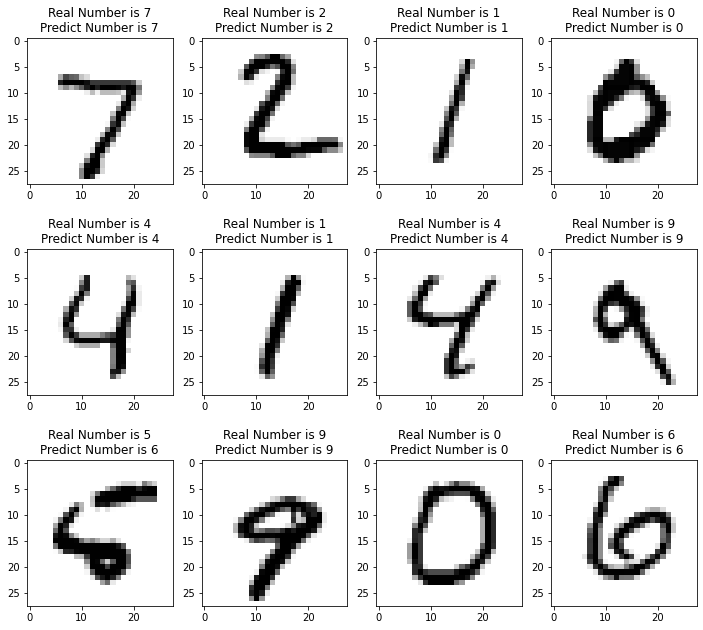

In [22]:
y_pred = model.predict(x_test)
X_test__ = x_test.reshape(x_test.shape[0], 28, 28)

fig, axis = plt.subplots(3, 4, figsize=(12, 11))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Number is {y_test[i].argmax()}\nPredict Number is {y_pred[i].argmax()}")

# Prediction

In [23]:
df_test = pd.read_csv('../input/digit-recognizer/test.csv')
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df_test = df_test.values.reshape(-1, 28, 28, 1)
df_test.shape


(28000, 28, 28, 1)

In [25]:
pred = model.predict(df_test, verbose=1)

875/875 [==============================] - 2s 2ms/step


In [26]:
LABELS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

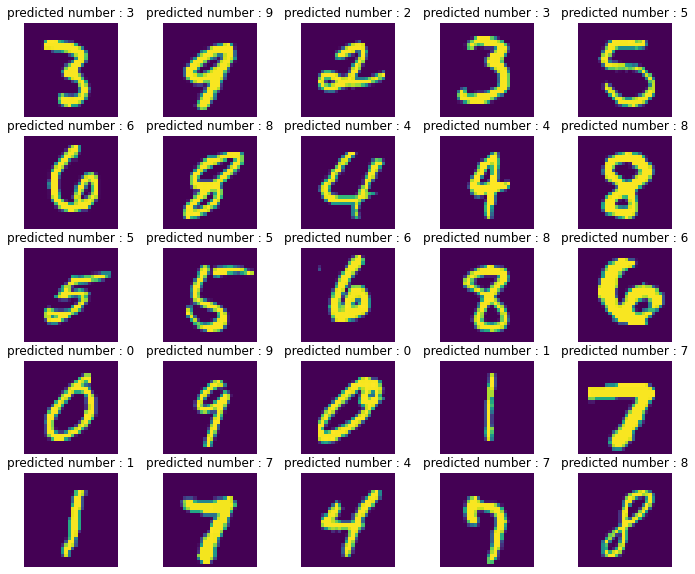

In [27]:
plt.figure(figsize=(12, 10))
for n, i in enumerate(list(np.random.randint(0, len(df_test), 25))):
    plt.subplot(5, 5, n+1)
    plt.imshow(array_to_img(df_test[i]))
    plt.axis('off')
    plt.title(f'predicted number : {LABELS[np.argmax(pred[i])]}')

##### Looking pretty good!!